# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Index Reversal Strategy Implementation

The S&P 500 index can be easily traded with various liquid instruments like futures, CFDs and ETFs. The popularity of the market index results in a market anomaly. Based on this anomaly, the index reversal strategy is built to exploit the negative price push on a "local minimum day" in the market. A position is taken towards the day end of a local minimum day. The position is closed at the end of the day whenever the "local minimum day" criterion is not met.

You will learn to implement the index reversal strategy in this notebook. For illustration, we will implement the strategy on the SPY ETF. 

This notebook is divided into the following parts:

1. [Read the Data](#read)
1. [Trading Signal](#signal)
1. [Strategy Returns](#returns)
1. [Performance Analysis](#analysis)
1. [Analysis Utility](#utility)
    
## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

The minute level ETF data is obtained from https://firstratedata.com/. The data used in this notebook can be downloaded from the downloadable unit at the end of the course.

For the index reversal strategy, we need the data one minute and two minutes before the market close. For illustration purpose, the SPY minute level data is available in two files:
1. Price data for one minute before market close is stored in the file named `SPY_data_15_59.csv`
1. Price data for two minutes before market close is stored in the file named `SPY_data_15_58.csv`

The data from these two files are read using the `read_csv` method of the `pandas` library.

In [2]:
# Read the price data for one minute before the close
price_one_minute_before_close = pd.read_csv(
    '../data_modules/SPY_data_15_59.csv', index_col=0, parse_dates=True)

# Read the price data for two minutes before the close
price_two_minute_before_close = pd.read_csv(
    '../data_modules/SPY_data_15_58.csv', index_col=0, parse_dates=True)

# Set the date as the index for both dataframes
price_one_minute_before_close.index = pd.to_datetime(
    price_one_minute_before_close.index.date)
price_two_minute_before_close.index = pd.to_datetime(
    price_two_minute_before_close.index.date)

# Preview the price data
print("Price data one minute before close:")
print(price_one_minute_before_close.head())
print("\n\nPrice data two minutes before close:")
print(price_two_minute_before_close.head())

Price data one minute before close:
              Open    High     Low   Close    Volume
2004-01-02  110.97  111.04  110.92  111.00  156600.0
2004-01-05  112.38  112.41  112.35  112.37  130500.0
2004-01-06  112.60  112.63  112.58  112.63  302300.0
2004-01-07  112.83  112.92  112.83  112.89  174300.0
2004-01-08  113.34  113.37  113.29  113.32  253900.0


Price data two minutes before close:
              Open    High     Low   Close    Volume
2004-01-02  110.95  110.98  110.93  110.96   82300.0
2004-01-05  112.41  112.41  112.35  112.37  110800.0
2004-01-06  112.61  112.62  112.58  112.61  211500.0
2004-01-07  112.85  112.86  112.82  112.86  135900.0
2004-01-08  113.35  113.35  113.32  113.35   59300.0




In the above section, we have downloaded the last minute ETF data from https://firstratedata.com/. However, if you wish to obtain this data from Yahoo Finance, you can run the following code. You will need to convert the cells from Raw NBConvert to Code cells to run them.

<a id='signal'></a>
## Trading Signal

The index reversal strategy defines the "local minimum day" as a day for which the price of SPY two minutes before close is at its ten-day period minimum. The strategy takes and keeps a long position till the "local minimum day" criterion is fulfilled. If the day is not a "local minimum day" then the position is closed.

The signal is calculated as follows:
1. Calculate the 10-day trailing minimum price.
1. Calculate the signal as buy for the days when the close price is equal to the trailing minimum price.

<br>
The logic flow can be represented as:
<html>
<img src=https://d2a032ejo53cab.cloudfront.net/Glossary/hqj2aqh9/nbstrat.jpg width=600>
</html>

In [3]:
# Define the local minimum period
period = 10

# Define a dataframe to store the signal and the returns
strategy = pd.DataFrame(
    index=price_two_minute_before_close.index)

# Calculate the trailing minimum price of the last ten days
price_two_minute_before_close['trailing_min'] = price_two_minute_before_close['Close'].rolling(
    period).min()

# Calculate the signal (1 for long, 0 for no position)
strategy['signal'] = np.where(
    price_two_minute_before_close["Close"] == price_two_minute_before_close["trailing_min"], 1, 0)

<a id='returns'></a>
## Strategy Returns

The strategy returns are calculated based on the price one minute before the market close. This is because all our trading actions for the index reversal strategy are executed at this time. The strategy returns are calculated for the period starting from 1st January 2005. This is done to ensure that the position sizing techniques we will apply in the upcoming sections can all be compared for the same time period.

In [4]:
# Define the initial capital
initial_capital = 10000

"""
Calculate the strategy returns
The signal is shifted by one because the pct_change gives the returns between the past and the
current period. The shifted signal, in effect, finds the returns between the current period and
the next period, after the next period's data is known.
"""
strategy['returns'] = price_one_minute_before_close['Close'].pct_change(
) * strategy['signal'].shift(1)

# Consider the data starting from 1st January 2005
strategy = strategy['2005-01-01':]

# Calculate the cumulative returns
strategy['cumulative_returns'] = (
    1 + strategy['returns']).cumprod()

<a id='analysis'></a>
## Performance Analysis

The total returns, annualised returns (CAGR), maximum drawdown and the return-to-maximum drawdown ratio are calculated.

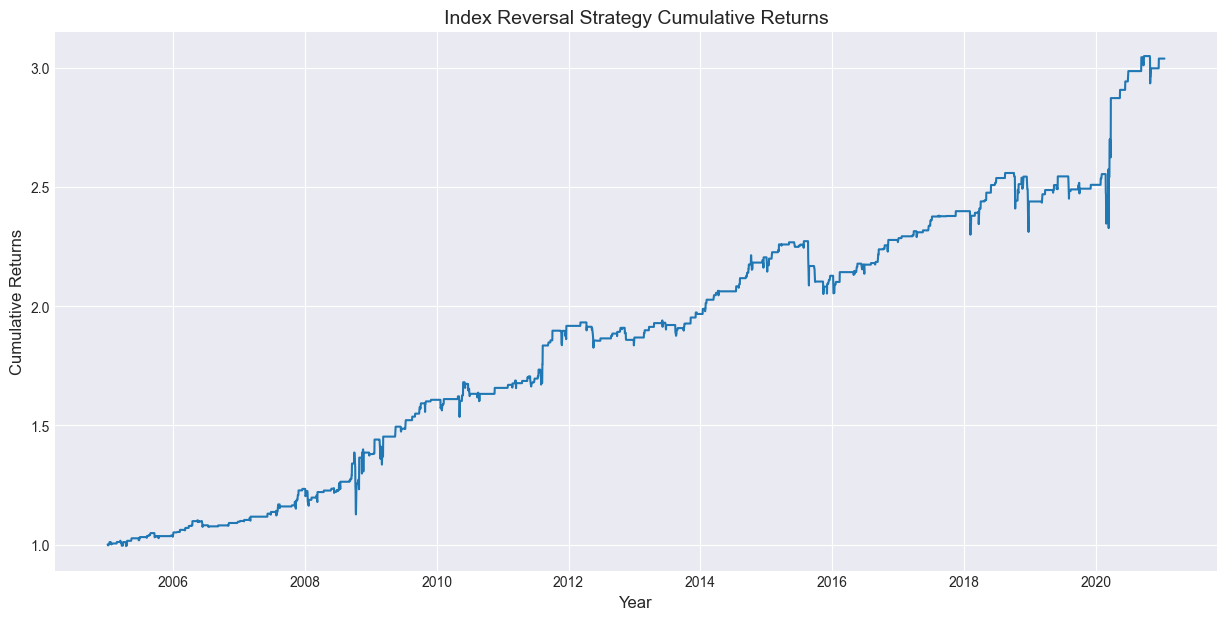

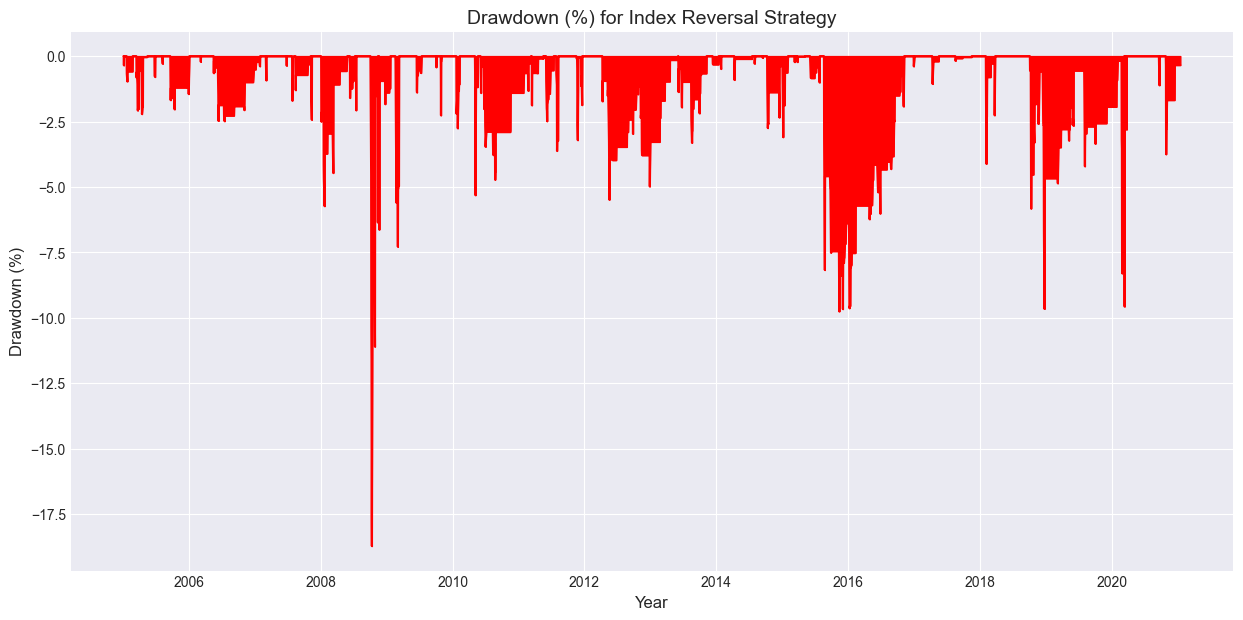

Total returns: 203.98%
Annualised returns (CAGR): 7.19%
Maximum drawdown (MDD): -18.72%
Return-to-MDD ratio: 0.38


In [5]:
# Store the final cumulative returns value
final_returns = strategy['cumulative_returns'].iloc[-1]

# Store the initial cumulative returns
initial_returns = strategy['cumulative_returns'].iloc[0]

# Store the number of trading days
trading_days = len(strategy['cumulative_returns'])

# Calculate the total returns
total_returns = (final_returns / initial_returns - 1) * 100

# Calculate the annualised returns
annualised_performace = ((final_returns / initial_returns)
                         ** (252 / trading_days) - 1) * 100

# Drawdown calculations
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy['cumulative_returns'].dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
running_drawdown = 100 * \
    ((strategy['cumulative_returns'])/running_max - 1)

# Calculate the maximum drawdown
max_drawdown = running_drawdown.min()

# Calculate the return to max. drawdown ratio
return_to_MDD_ratio = annualised_performace / max_drawdown

# Plot the cumulative returns
plt.figure(figsize=(15, 7))
plt.title('Index Reversal Strategy Cumulative Returns', fontsize=14)
plt.plot(
    strategy['cumulative_returns'], label="Cumulative Returns")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

# Plot max DD
plt.figure(figsize=(15, 7))
plt.title('Drawdown (%) for Index Reversal Strategy', fontsize=14)
plt.plot(running_drawdown, color='red')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Drawdown (%)', fontsize=12)
plt.fill_between(running_drawdown.index, running_drawdown.values, color='red')
plt.show()

# Print the performance metrics
print(f"Total returns: {round(total_returns, 2)}%")
print(f"Annualised returns (CAGR): {round(annualised_performace, 2)}%")
print(f"Maximum drawdown (MDD): {round(max_drawdown, 2)}%")
print(f"Return-to-MDD ratio: {abs(round(return_to_MDD_ratio, 2))}")

<a id='utility'></a>
## Analysis Utility

The performance metrics and the graph plotting is put in a function called `performance_analysis`. This is done so that you can easily calculate these metrics for the upcoming position sizing techniques. This function is placed in the `position_sizing_quantra.py` file located in the `data_modules` folder. The Jupyter notebooks and the `data_modules` folder can be downloaded from the last section of the course.

The `performance_analysis` function accepts two arguments.
1. `strategy_portfolio_value`: The strategy portfolio value you want to evaluate.
1. `benchmark_portfolio_value`: The benchmark portfolio value of the index reversal strategy without any position sizing technique applied. This argument is optional.

In [6]:
"""
Function to print the portfolio performance metrics and plot the portfolio value
along with the drawdown.
"""


def performance_analysis(strategy_portfolio_value, benchmark_portfolio_value=None):
    # Store the final cumulative returns value
    final_returns = strategy_portfolio_value.iloc[-1]

    # Store the initial cumulative returns
    initial_returns = strategy_portfolio_value.iloc[0]

    # Store the number of trading days
    trading_days = len(strategy_portfolio_value)

    # Calculate the total returns
    total_returns = (final_returns / initial_returns - 1) * 100

    # Calculate the annualised returns
    annualised_performace = ((final_returns / initial_returns)
                             ** (252 / trading_days) - 1) * 100

    # Drawdown calculations
    # Calculate the running maximum
    running_max = np.maximum.accumulate(
        strategy_portfolio_value.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    running_drawdown = 100 * \
        ((strategy_portfolio_value)/running_max - 1)

    # Calculate the maximum drawdown
    max_drawdown = running_drawdown.min()

    # Calculate the return to max. drawdown ratio
    return_to_MDD_ratio = annualised_performace / max_drawdown

    # Plot the cumulative returns
    plt.figure(figsize=(15, 7))
    plt.title('Portfolio Value ($)', fontsize=14)

    plt.plot(
        strategy_portfolio_value, label="Strategy Performance")

    if benchmark_portfolio_value is not None:
        plt.plot(benchmark_portfolio_value, label="Benchmark Performance")

    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Portfolio Value ($)', fontsize=12)
    plt.legend()
    plt.show()

    # Plot max drawdown
    plt.figure(figsize=(15, 7))
    plt.title('Drawdown (%)', fontsize=14)
    plt.plot(running_drawdown, color='red')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.fill_between(running_drawdown.index,
                     running_drawdown.values, color='red')
    plt.show()

    # Print the performance metrics
    print(f"Total returns: {round(total_returns, 2)}%")
    print(f"Annualised returns (CAGR): {round(annualised_performace, 2)}%")
    print(f"Maximum drawdown (MDD): {round(max_drawdown, 2)}%")
    print(f"Return-to-MDD ratio: {abs(round(return_to_MDD_ratio, 2))}")

### Use the Analysis Utility

We will now pass the strategy portfolio values to the `performance_analysis` function and get the performance metrics.
To do that, we first calculate the portfolio values by multiplying the initial capital and the cumulative returns.

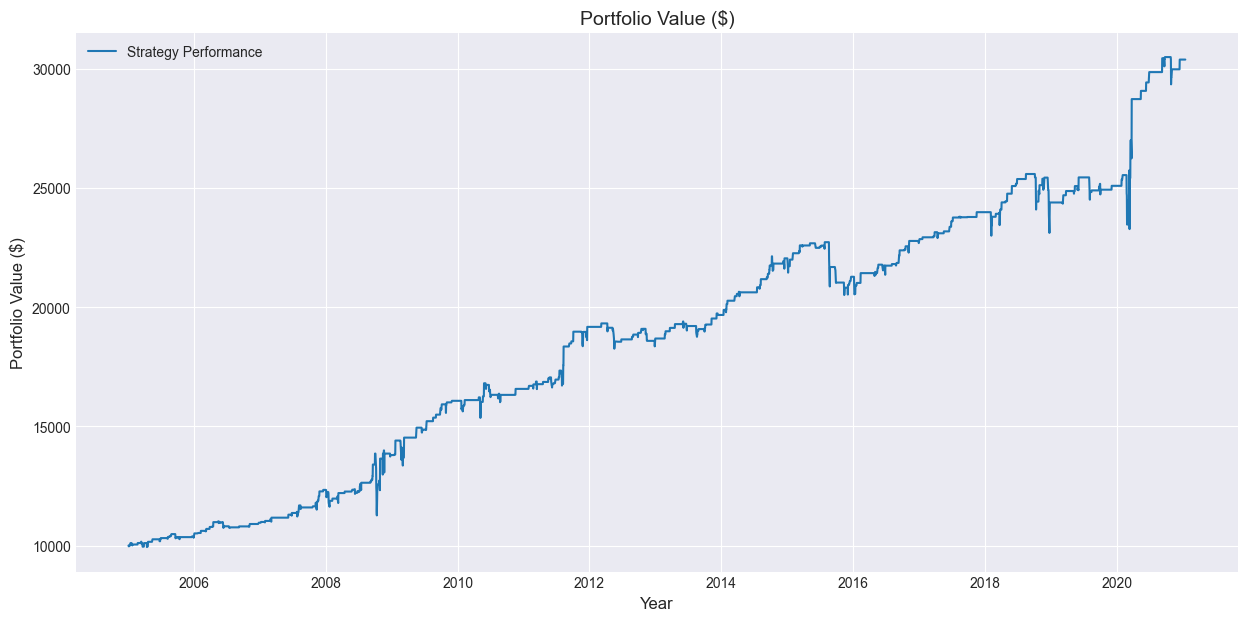

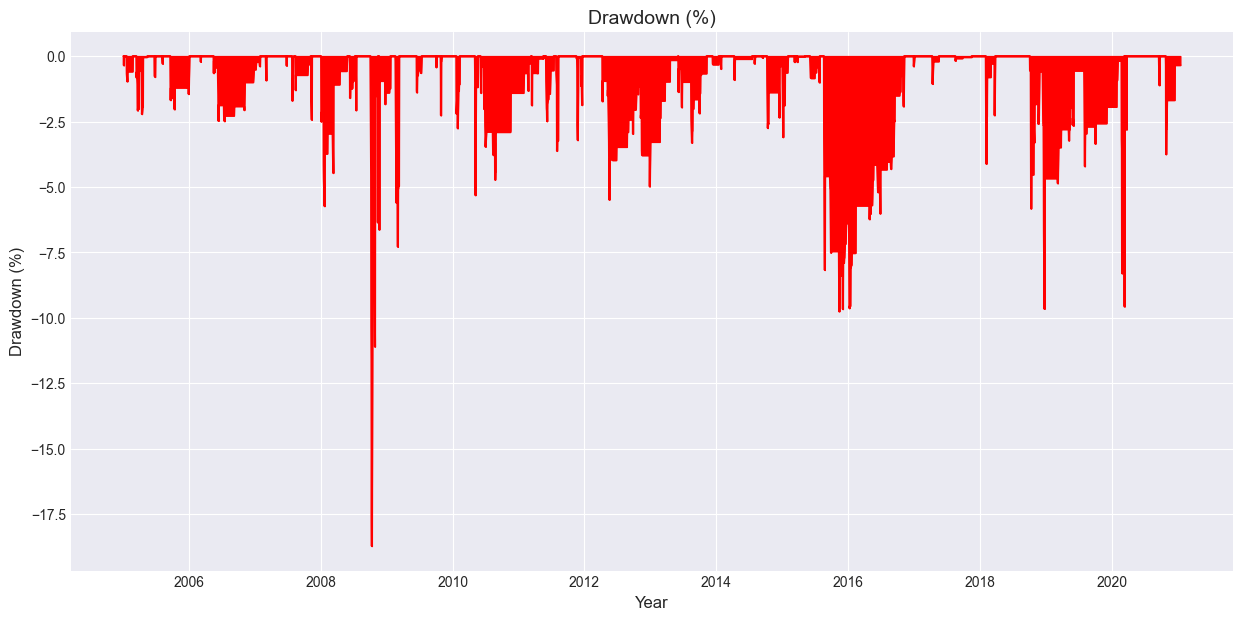

Total returns: 203.98%
Annualised returns (CAGR): 7.19%
Maximum drawdown (MDD): -18.72%
Return-to-MDD ratio: 0.38


In [7]:
# Calculate the portfolio value
strategy['portfolio'] = strategy['cumulative_returns'] * initial_capital

# Call the performance analysis function
performance_analysis(strategy['portfolio'])

In the upcoming sections, you will learn about various position sizing techniques and their implementation.
<br><br>